<a href="https://colab.research.google.com/github/Carolinsrainbow/UC_SistemasRecomendadores/blob/main/Tarea_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 3 - MAN3160



**Profesor**: Denis Parra

**Ayudante**: Álvaro Labarca.


En esta tarea, se utilizará la biblioteca DeepCTR-Torch para generar un sistema recomendador que utiliza información de contenido y contexto.

## Descarga del dataset

Nuevamente, se utilizará el dataset MovieLens-100k para esta tarea.

In [26]:
!pip install wget
!pip install zipfile36
!pip3 install implicit --upgrade
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!pip install deepctr-torch
!pip install tensorflow


Saved under ml-100k (1).zip


In [27]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [28]:
# Pueden importar más librerías si es necesario

import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import implicit
import scipy.sparse as sparse
import time
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from deepctr_torch.inputs import SparseFeat, VarLenSparseFeat, get_feature_names
from deepctr_torch.models import DeepFM

In [29]:
def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            # Notice : input value 0 is a special "padding",so we do not use 0 to encode valid feature for sequence input
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

In [30]:
dir_train = 'ml-100k'

# Generamos los títulos de las columnas del archivo items.

columns = ['itemid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [31]:
df = pd.read_csv(f'{dir_train}/u.data',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

In [32]:
df_items = pd.read_csv(f'{dir_train}/u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None,
                        encoding='latin-1')

In [33]:
columns_user = ['userid', 'age', 'gender', 'occupation', 'zip_code']

In [34]:
df_users = pd.read_csv(f'{dir_train}/u.user',
                        sep='|',
                        index_col=0,
                        names = columns_user,
                        header=None,
                        encoding='latin-1')

df_users = df_users.reset_index()
df_items = df_items.reset_index()

In [35]:
df_total = pd.merge(df, df_users, on='userid')
df_total = pd.merge(df_total, df_items, on='itemid')

In [36]:
def combine_genres(row):
    genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
    return '|'.join([col for col, val in row.items() if val == 1 and col in genres])

In [37]:
df_total['genres'] = df_total.apply(combine_genres, axis=1)

In [38]:
genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
df_total = df_total.drop(genres, axis=1)

In [39]:
df_total.sort_values(by='timestamp').head(10)

,userid,itemid,rating,timestamp,age,gender,occupation,zip_code,title,release_date,video_release_date,IMDb_URL,unknown,genres
214,259,255,4,874724710,21,M,student,48823,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,Comedy|Romance
83965,259,286,4,874724727,21,M,student,48823,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,Drama|Romance|War
43027,259,298,4,874724754,21,M,student,48823,Face/Off (1997),27-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Face/Off+(1997),0,Action|Sci-Fi|Thriller
21396,259,185,4,874724781,21,M,student,48823,Psycho (1960),01-Jan-1960,NaN,http://us.imdb.com/M/title-exact?Psycho%20(1960),0,Horror|Romance|Thriller
82655,259,173,4,874724843,21,M,student,48823,"Princess Bride, The (1987)",01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Princess%20Br...,0,Action|Adventure|Comedy|Romance
10891,259,108,4,874724882,21,M,student,48823,Kids in the Hall: Brain Candy (1996),12-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Kids%20in%20t...,0,Comedy
1766,259,772,4,874724882,21,M,student,48823,Kids (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Kids%20(1995),0,Drama
26399,259,288,3,874724905,21,M,student,48823,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,Horror|Thriller
85297,259,928,4,874724937,21,M,student,48823,"Craft, The (1996)",26-Apr-1996,NaN,"http://us.imdb.com/M/title-exact?Craft,%20The%...",0,Drama|Horror
159,259,117,4,874724988,21,M,student,48823,"Rock, The (1996)",07-Jun-1996,NaN,"http://us.imdb.com/M/title-exact?Rock,%20The%2...",0,Action|Adventure|Thriller


# Actividades

### Actividad 1: Análisis de características de contenido.

En el tutorial de DeepCTR-torch, se dio un ejemplo del entrenamiento de un modelo con DeepCTR-torch que combinó data de contexto y de contenido. En esta tarea, se realizará un procedimiento similar. Se les proporcionó el código para generar el dataframe df_total, el cual contiene todo los metadatos de contenido para cada interacción. Esta primera actividad se tratará de seleccionar los datos de contenido que usarán y realicen un análisis de ello. Lo que deben hacer es:

* Seleccionar las columnas de contenido que creen que proporcionan información que puede ser aprovechada por un algoritmo recomendador. Deben elegir al menos dos características del usuario y dos características de los ítems. Se debe indicar explícitamente la información seleccionada y entregar una breve justificación de por qué esta información podría ser útil al realizar una recomendación.
* Elija dos de las características que seleccionó en el paso anterior (pueden ser de usuario y/o ítem) y grafique sus distribuciones. Por ejemplo, si eligió la edad, grafique un histograma con la distribución de edad de los usuarios. Comente acerca de esta distribución. Calcule y entregue además el promedio y desviación estándar de esta distribución si es una característica no discreta o bien, el valor más popular y menos popular si es una característica discreta.

#### Respuesta Actividad 1:

La construcción del sistema de recomendación tuvo como base dos características de usuario y dos de ítem, donde se consideró relevantes para modelar el comportamiento y las preferencias, siendo estas:


#### Características de Usuario

* **Edad (age)**: La edad de los usuarios puede influir significativamente en las preferencias cinematográficas. Usuarios de distintas generaciones suelen preferir diferentes tipos de películas, tanto en términos de género como de época y contexto de lanzamiento. Por ejemplo, los jóvenes pueden preferir películas de acción o comedia, mientras que las personas mayores podrían inclinarse más por dramas o clásicos. Esta información es clave para personalizar las recomendaciones.

* **Género (gender)**: El género puede influir en las preferencias de consumo de películas. Existen diferencias culturales y de comportamiento que hacen que las personas de diferentes géneros tiendan a preferir distintos géneros cinematográficos o estilos narrativos. Por ejemplo, puede que las películas de acción sean más populares entre los hombres y las de romance o comedia entre las mujeres. El tener en cuenta esta variable permite personalizar las recomendaciones en función de tendencias generales observadas en cada género.

#### Características de Ítem

* **Año de estreno (release_date)**: La fecha de lanzamiento puede ser importante para hacer recomendaciones. Los usuarios pueden tener diferentes preferencias dependiendo de si la película es nueva o clásica. Además, podría existir una tendencia a que las personas más jóvenes prefieran ver películas recientes, mientras que los usuarios mayores podrían estar más inclinados a ver películas más antiguas.

* **Género de la película (genres)**: Los géneros de las películas son fundamentales para las recomendaciones, ya que los usuarios suelen tener afinidad por ciertos géneros (acción, comedia, drama, etc.). Al conocer los géneros de las películas que un usuario ha calificado positivamente, podemos recomendarle otras películas dentro del mismo género.

---

Adicionalmente, se graficaron la distribución de las variables `gender` y `release_year` para observar sus patrones en los datos.

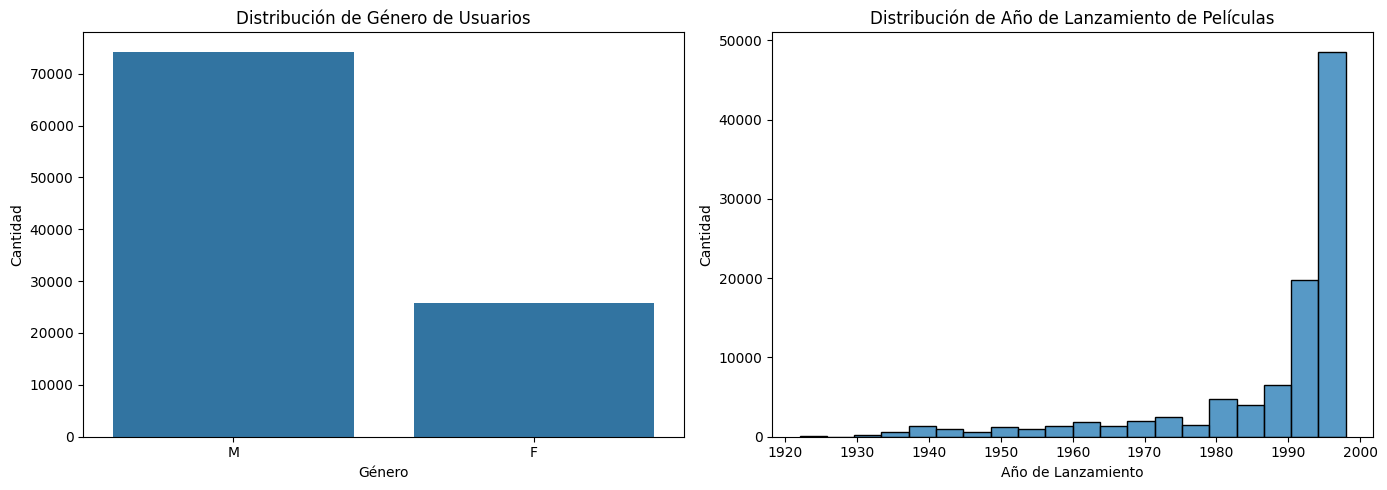

In [40]:
# Primero, convertir a formato de fecha
df_total['release_date'] = pd.to_datetime(df_total['release_date'], errors='coerce')

# Luego, crear una nueva columna extrayendo solo el año
df_total['release_year'] = df_total['release_date'].dt.year

# Imp biblio
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Distribución de 'gender'
sns.countplot(x='gender', data=df_total, ax=axs[0])
axs[0].set_title('Distribución de Género de Usuarios')
axs[0].set_xlabel('Género')
axs[0].set_ylabel('Cantidad')

# Gráfico 2: Distribución de 'release_year'
sns.histplot(df_total['release_year'], bins=20, ax=axs[1])
axs[1].set_title('Distribución de Año de Lanzamiento de Películas')
axs[1].set_xlabel('Año de Lanzamiento')
axs[1].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()

Tratamiento de datos:

In [41]:
genres_movies_dict = {}

for index, row in df_total.iterrows():
    item_id = row['itemid']
    genres = row['genres'].split('|')  # Divide los géneros por "|"
    genres_movies_dict[item_id] = genres

all_genres = []
for item_id, genres in genres_movies_dict.items():
    all_genres.extend(genres)

Para tener una mejor visualización de los años de lanzamiento, los podemos agrupar por década, separando en 2 grandes grupos: 80's y 90's.

In [42]:
df_total['release_date'].fillna('01-Jan-1900', inplace=True)
df_total['dec_release'] = pd.to_datetime(df_total['release_date'], format='%d-%b-%Y').dt.year.astype('int').apply(lambda x: '80s' if x <= 1989 else '90s')

<ipython-input-43-92f99d47512e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dec_release', y='conteo', data=tabla_dec_release, palette='Set1')


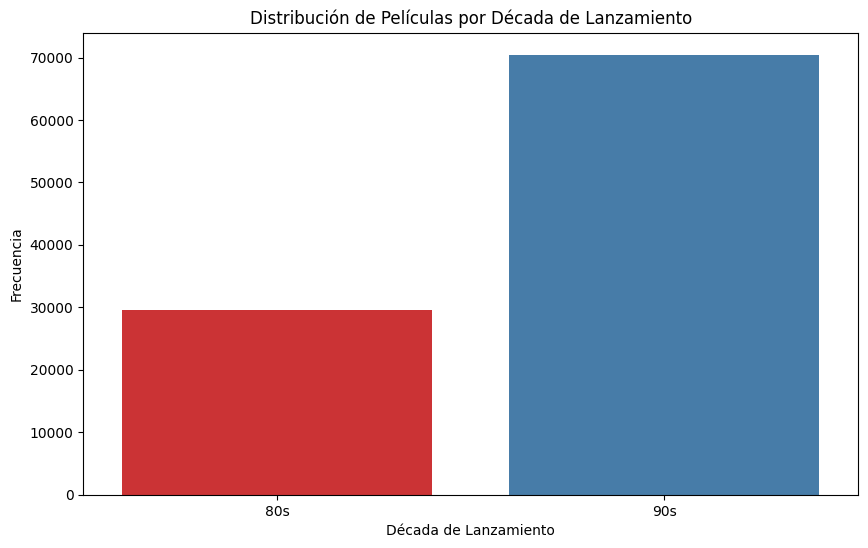

In [43]:
# Contar frecuencias por década
tabla_dec_release = df_total.groupby(['dec_release']).size().reset_index().rename(columns={0: 'conteo'})
tabla_dec_release['perc'] = tabla_dec_release['conteo'] / tabla_dec_release['conteo'].sum()

# Gráfico de barras de Década de Lanzamiento
plt.figure(figsize=(10,6))
sns.barplot(x='dec_release', y='conteo', data=tabla_dec_release, palette='Set1')

plt.title("Distribución de Películas por Década de Lanzamiento")
plt.xlabel("Década de Lanzamiento")
plt.ylabel("Frecuencia")

plt.show()

Resumen de distribuciones:

In [44]:
# Cálculo de los valores más populares y menos populares para Género de Usuario
tabla_gender = df_total.groupby(['gender']).size().reset_index().rename(columns={0: 'conteo'})
most_popular_gender = tabla_gender.loc[tabla_gender['conteo'].idxmax()]['gender']
least_popular_gender = tabla_gender.loc[tabla_gender['conteo'].idxmin()]['gender']

# Cálculo de los valores más populares y menos populares para Año de Lanzamiento
most_popular_year = df_total['release_date'].dt.year.value_counts().idxmax()
least_popular_year = df_total['release_date'].dt.year.value_counts().idxmin()

# Cálculo de los valores más populares y menos populares para Década de Lanzamiento
tabla_dec_release = df_total.groupby(['dec_release']).size().reset_index().rename(columns={0: 'conteo'})
most_popular_decade = tabla_dec_release.loc[tabla_dec_release['conteo'].idxmax()]['dec_release']
least_popular_decade = tabla_dec_release.loc[tabla_dec_release['conteo'].idxmin()]['dec_release']

# Tabla con los valores más populares y menos populares
resultados_populares = pd.DataFrame({
    'Característica': ['Género de Usuario', 'Año de Lanzamiento', 'Década de Lanzamiento'],
    'Más Popular': [
        most_popular_gender,
        most_popular_year,
        most_popular_decade
    ],
    'Menos Popular': [
        least_popular_gender,
        least_popular_year,
        least_popular_decade
    ]
})

# Mostrar la tabla
resultados_populares

,Característica,Más Popular,Menos Popular
0,Género de Usuario,M,F
1,Año de Lanzamiento,1996,1926
2,Década de Lanzamiento,90s,80s


## Observaciones de las distribuciones

1. Género de Usuario: El histograma de género muestra una clara predominancia de usuarios masculinos sobre femeninos en el conjunto de datos. Esto puede reflejarse en el tipo de contenido que se encuentra en la base de datos (películas, géneros, etc.) que podría ser más atractivo o accesible para el género masculino, o puede estar relacionado con cómo se recopila la información de género en este caso. Sin embargo, hay que tener en cuenta que esta disparidad podría estar influenciada por el sesgo en la población de usuarios o en el sistema de recomendación. Es importante considerar estos factores al analizar las preferencias y diseñar las recomendaciones para no excluyendo a un grupo específico.

2. Año de Lanzamiento: El histograma de la fecha de lanzamiento de las películas muestra que el año 1996 es el más popular, lo que sugiere que muchas de las películas en este conjunto de datos pertenecen a esa época. Esto podría reflejar un interés significativo en películas de los 90s o simplemente una disponibilidad más amplia de contenido en esa época. Por otro lado, el año 1926 es el menos popular, lo que probablemente se deba a que las películas de esa época son menos comunes en plataformas actuales, o a que los usuarios tienden a consumir más contenido reciente. Este patrón también puede sugerir una desconexión entre generaciones, donde los usuarios más jóvenes pueden no estar tan interesados en películas tan antiguas.

* Década de Lanzamiento: En cuanto a las décadas, los 90s son la más representada en el conjunto de datos, lo que indica que este período fue clave en la producción de películas populares o que hay un mayor número de películas catalogadas como de esa época en la base de datos. La década de los 80s es la menos popular, lo cual podría indicar que la oferta de películas de esa década es menor o que los usuarios actuales prefieren otros períodos, probablemente porque muchas de las películas de los 80s tienen un enfoque diferente o están más desactualizadas en comparación con las producciones de los 90s o años más recientes.

En resumen:

- Los usuarios masculinos son más frecuentes, lo cual puede influir en el tipo de películas que se consumen o en cómo se recopila la información.
- Las películas de 1996 son las más populares, mientras que las de 1926 son extremadamente raras en el conjunto de datos, probablemente debido a la antigüedad de las películas.
- Década de Lanzamiento: Los 90s dominan como la década más popular, mientras que los 80s tienen menos representación, lo cual puede reflejar preferencias o disponibilidad de contenido.

### Actividad 2: Generación de característica de contexto.

En el ejemplo del tutorial, se generó a partir del timestamp una característica discreta que indicaba si una calificación fue ingresada en la mañana, tarde o noche.

* A partir del timestamp (ya que este es la única característica contextual del dataset), capture otra característica contextual que pueda ser utilizada en el entrenamiento (que no sea una división de mañana/tarde/noche). Justifique su elección explicando por qué se podría aprovechar esa información de contexto para generar mejores recomendaciones. Puede asumir que el timestamp indica la hora en que fue vista la película (en lugar de la hora en la que fue ingresada la calificación) y que todos los usuarios están en la zona horaria entregada por la conversión a dataframe mostrada por la ayudantía.
* Genere una hipótesis de cómo podría influir la variable contextual en la recomendación. (Por ejemplo, una hipótesis podría ser que en la noche, se deberían recomendar una mayor cantidad de películas de terror).

In [45]:
#Código Actividad 2

import pandas as pd

# Aseguramos que 'timestamp' esté en formato datetime
df_total['timestamp'] = pd.to_datetime(df_total['timestamp'], unit='s')

# Creamos nueva columna 'day_of_week'
df_total['day_of_week'] = df_total['timestamp'].dt.day_name()

# Crear nueva columna 'day_type' como 'workdays' o 'weekend'
df_total['day_type'] = df_total['day_of_week'].apply(lambda x: 'weekend' if x in ['Saturday', 'Sunday'] else 'workdays')

# Verificar
df_total[['timestamp', 'day_of_week', 'day_type']].head()


,timestamp,day_of_week,day_type
0,1997-12-04 15:55:49,Thursday,workdays
1,1998-04-04 19:22:22,Saturday,weekend
2,1997-11-07 07:18:36,Friday,workdays
3,1997-11-27 05:02:03,Thursday,workdays
4,1998-02-02 05:33:16,Monday,workdays


#### Respuesta Actividad 2:

A partir del campo `timestamp`, se creó una nueva característica contextual denominada `day_type`, que clasifica cada visualización como `workdays` (de lunes a viernes) o `weekend` (sábado o domingo).

#### Justificación

La elección de dividir los días de la semana en días laborales (workdays) y fin de semana (weekend) es relevante porque las actividades y patrones de consumo de los usuarios varían dependiendo de si están en una jornada laboral o de descanso. Al observar el comportamiento de los usuarios en estos dos contextos, se pueden identificar diferencias significativas en las preferencias cinematográficas.

* Días laborales (lunes a viernes): Durante la semana, los usuarios tienden a estar más ocupados con sus responsabilidades (trabajo, estudios, etc.). Esto podría llevar a que prefieran películas más cortas o ligeras, como comedias, películas familiares o dramas que no requieran tanto tiempo de concentración. Además, es posible que los usuarios vean películas al final del día después del trabajo o la universidad, lo que podría influir en sus elecciones.

* Fin de semana (sábado y domingo): En contraste, durante los fines de semana, los usuarios tienen más tiempo libre, lo que podría llevarlos a elegir películas más largas o intensas, como películas de acción, thrillers, o incluso películas de terror, que pueden requerir mayor dedicación. Además, los fines de semana son momentos en los que las personas se relajan más, por lo que pueden preferir ver películas que impliquen una experiencia más inmersiva o social, como ver películas en grupo o con la familia.

#### Hipótesis

La característica contextual del día de la semana puede influir en las recomendaciones de películas al considerar el tipo de contenido que es más adecuado para los diferentes momentos de la semana:

En días laborales (lunes a viernes), es probable que los usuarios prefieran películas más ligeras, cortas o familiares, ya que tienen menos tiempo libre y están buscando algo rápido y fácil de consumir al final de su día.

En el fin de semana (sábado y domingo), los usuarios pueden estar más dispuestos a ver películas más largas o intensas, como películas de acción, terror o películas que involucren una experiencia más social o emocional. Los fines de semana son momentos ideales para disfrutar de películas que pueden requerir más tiempo y concentración.

En concreto:

*Esperamos que los usuarios que ven películas durante el `weekend` tiendan a preferir géneros como drama o ciencia ficción, mientras que durante los `workdays` opten más por géneros ligeros como comedia o acción.*


### Actividad 3: Entrenamiento Modelos.

Entrene modelos de recomendación utilizando la librería DeepCTR-torch.

* El primer modelo debe contener solo la información de las interacciones, es decir, usuario, item y rating.
* Al segundo modelo se le deben agregar las caracterísitcas de contenido.
* El tercer modelo debe tener la característica contextual.

Recuerde que antes de entrenar, se debe generar la división train-test del dataset.

Recuerde variar los hiperparámetros para obtener mejores resultados y entrene por al menos 12 épocas cada modelo.

#### Respuesta Actividad 3:

#### Primer Modelo: usuario, item y rating

In [48]:
# Librerías necesarias
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
from deepctr_torch.models import DeepFM
from deepctr_torch.inputs import SparseFeat, get_feature_names

# Paso 1: Definir sparse_features
sparse_features = ['userid', 'itemid', 'gender', 'age', 'occupation', 'zip_code', 'genres', 'release_year', 'day_type']
target = ['rating']

# Paso 2: Label Encoding
for feat in sparse_features:
    lbe = LabelEncoder()
    df_total[feat] = lbe.fit_transform(df_total[feat])

# Paso 3: Train/Test Split
train, test = train_test_split(df_total, test_size=0.2, random_state=42)

# Paso 4: Crear feature columns
fixlen_feature_columns = [
    SparseFeat(feat, vocabulary_size=df_total[feat].nunique(), embedding_dim=8)
    for feat in sparse_features
]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

# Paso 5: Preparar inputs
train_model_input = {name: train[name].values for name in feature_names}
test_model_input = {name: test[name].values for name in feature_names}

# Paso 6: Definir modelo DeepFM
model = DeepFM(
    linear_feature_columns=linear_feature_columns,
    dnn_feature_columns=dnn_feature_columns,
    task='regression',
    l2_reg_linear=1e-5,
    dnn_hidden_units=(256, 128),
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Paso 7: Compilar (solo MSE)
model.compile("adam", "mse", metrics=["mse"])

# Paso 8: Entrenar (SIN metrics aquí)
history = model.fit(
    train_model_input, train[target].values,
    batch_size=512,
    epochs=12,
    verbose=2,
    validation_split=0.2
)

# Paso 9: Predecir
pred_ans = model.predict(test_model_input, batch_size=512)

# Paso 10: Calcular MSE
mse_score = mean_squared_error(test[target].values, pred_ans)
print(f"MSE en test set: {mse_score:.4f}")


cpu
Train on 64000 samples, validate on 16000 samples, 125 steps per epoch
Epoch 1/12
4s - loss:  3.1798 - mse:  3.1798 - val_mse:  0.9461
Epoch 2/12
7s - loss:  0.8947 - mse:  0.8947 - val_mse:  0.8957
Epoch 3/12
5s - loss:  0.8680 - mse:  0.8680 - val_mse:  0.8909
Epoch 4/12
3s - loss:  0.8601 - mse:  0.8601 - val_mse:  0.8910
Epoch 5/12
3s - loss:  0.8569 - mse:  0.8569 - val_mse:  0.8899
Epoch 6/12
2s - loss:  0.8551 - mse:  0.8551 - val_mse:  0.8909
Epoch 7/12
2s - loss:  0.8530 - mse:  0.8530 - val_mse:  0.8935
Epoch 8/12
2s - loss:  0.8520 - mse:  0.8520 - val_mse:  0.8897
Epoch 9/12
3s - loss:  0.8502 - mse:  0.8502 - val_mse:  0.8926
Epoch 10/12
2s - loss:  0.8504 - mse:  0.8504 - val_mse:  0.8921
Epoch 11/12
2s - loss:  0.8493 - mse:  0.8493 - val_mse:  0.8900
Epoch 12/12
2s - loss:  0.8472 - mse:  0.8472 - val_mse:  0.8903
MSE en test set: 0.8942


In [49]:
# Importar modelo
from deepctr_torch.models import xDeepFM

# Definir modelo xDeepFM
model_xdeepfm = xDeepFM(
    linear_feature_columns=linear_feature_columns,
    dnn_feature_columns=dnn_feature_columns,
    task='regression',
    cin_layer_size=(128, 128),  # Ajuste de hiperparámetro CIN
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Compilar el modelo (solo MSE como métrica)
model_xdeepfm.compile("adam", "mse", metrics=["mse"])

# Entrenar el modelo
history_xdeepfm = model_xdeepfm.fit(
    train_model_input, train[target].values,
    batch_size=512,
    epochs=12,
    verbose=2,
    validation_split=0.2
)

# Predecir en test
pred_ans_xdeepfm = model_xdeepfm.predict(test_model_input, batch_size=512)

# Evaluar solo MSE
mse_score_xdeepfm = mean_squared_error(test[target].values, pred_ans_xdeepfm)
print(f"MSE en test set (xDeepFM): {mse_score_xdeepfm:.4f}")


cpu
Train on 64000 samples, validate on 16000 samples, 125 steps per epoch
Epoch 1/12
16s - loss:  1.9114 - mse:  1.9114 - val_mse:  0.9243
Epoch 2/12
14s - loss:  0.8854 - mse:  0.8854 - val_mse:  0.8960
Epoch 3/12
14s - loss:  0.8630 - mse:  0.8630 - val_mse:  0.8876
Epoch 4/12
14s - loss:  0.8551 - mse:  0.8551 - val_mse:  0.8874
Epoch 5/12
14s - loss:  0.8514 - mse:  0.8514 - val_mse:  0.8859
Epoch 6/12
14s - loss:  0.8489 - mse:  0.8489 - val_mse:  0.8852
Epoch 7/12
13s - loss:  0.8456 - mse:  0.8456 - val_mse:  0.8819
Epoch 8/12
14s - loss:  0.8431 - mse:  0.8430 - val_mse:  0.8833
Epoch 9/12
13s - loss:  0.8410 - mse:  0.8410 - val_mse:  0.8818
Epoch 10/12
14s - loss:  0.8386 - mse:  0.8386 - val_mse:  0.8803
Epoch 11/12
14s - loss:  0.8342 - mse:  0.8342 - val_mse:  0.8767
Epoch 12/12
14s - loss:  0.8289 - mse:  0.8289 - val_mse:  0.8763
MSE en test set (xDeepFM): 0.8840


In [51]:
from lightfm import LightFM
from lightfm.evaluation import auc_score
import scipy.sparse as sp

# Definir número total de usuarios e ítems
num_users = df_total['userid'].nunique()
num_items = df_total['itemid'].nunique()

# Crear matriz de interacciones TRAIN
train_interactions = sp.coo_matrix(
    (train['rating'].values,
     (train['userid'].values, train['itemid'].values)),
    shape=(num_users, num_items)
)

# Crear matriz de interacciones TEST
test_interactions = sp.coo_matrix(
    (test['rating'].values,
     (test['userid'].values, test['itemid'].values)),
    shape=(num_users, num_items)
)

# Definir modelo
model_lightfm = LightFM(loss='warp')

# Entrenar modelo
model_lightfm.fit(train_interactions, epochs=12, num_threads=4, verbose=True)

# Evaluar AUC sobre TEST
test_auc = auc_score(
    model_lightfm,
    test_interactions,
    train_interactions=train_interactions,
    num_threads=4
).mean()

print(f"AUC en test set (LightFM): {test_auc:.4f}")


Epoch: 100%|██████████| 12/12 [00:01<00:00,  9.27it/s]


AUC en test set (LightFM): 0.9264


### Actividad 4: Evaluación de rendimiento.

Genere una tabla comparando el rendimiento de los tres modelos generados. Evalúe con la métrica AUC y MSE. Comente qué método obtuvo el mejor resultado.

In [52]:

# Resultados obtenidos anteriormente

mse_deepfm = mse_score
mse_xdeepfm = mse_score_xdeepfm
auc_lightfm = test_auc

# Crear DataFrame resumen
resultados_modelos = pd.DataFrame({
    'Modelo': ['DeepFM', 'xDeepFM', 'LightFM'],
    'Métrica utilizada': ['MSE', 'MSE', 'AUC'],
    'Resultado': [mse_deepfm, mse_xdeepfm, auc_lightfm]
})

# Mostrar tabla
print(resultados_modelos)


    Modelo Métrica utilizada  Resultado
0   DeepFM               MSE   0.894237
1  xDeepFM               MSE   0.883981
2  LightFM               AUC   0.926418


#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

### Actividad 5: Evaluación de hipótesis.

Realice una evaluación de la hipótesis que generó en la Actividad 2 en base a las recomendaciones que entrega su modelo contextual. Por ejemplo, para evaluar la hipótesis dada de ejemplo en la Actividad 2, se podrían analizar las recomendaciones dadas a usuarios en distintos bloques horarios y analizar si en el bloque nocturno existe una mayor densidad de películas de terror.

Comente respecto al resultado de su evaluación. Recuerde que la hipótesis no necesariamente debe estar correcta, en especial debido a los supuestos realizados en el entrenamiento. Sugiera una posible mejoría al diseño experimental para poder obtener un mejor análisis de su hipótesis.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.